<a href="https://colab.research.google.com/github/aa23amd/HYBRID-ML-BASED-SUB-SEASONAL-WEATHER-FORECASTING/blob/main/CROSS%20VALIDATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MOUNTING DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


LOADING AND PREPROCESSING THE DATA

In [36]:
import pandas as pd
!unzip -o "/content/drive/MyDrive/train_data.csv.zip" -d /content/

# Update the path to your dataset on Drive.
csv_path = "/content/train_data.csv"
train_df = pd.read_csv(csv_path)
print("Original train_df shape:", train_df.shape)

# Define your target column.
target_column = 'contest-precip-14d__precip'

# Drop non-numeric columns such as 'startdate' and 'climateregions__climateregion'
cols_to_drop = ['startdate', 'climateregions__climateregion']
train_df = train_df.drop(cols_to_drop, axis=1, errors='ignore')
print("Columns after dropping unwanted ones:", train_df.columns.tolist())



Archive:  /content/drive/MyDrive/train_data.csv.zip
  inflating: /content/train_data.csv  
Original train_df shape: (375734, 246)
Columns after dropping unwanted ones: ['index', 'lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-p

handling missing values

In [5]:
# Separate features and target.
features_df = train_df.drop(target_column, axis=1)
target_series = train_df[target_column]

# Check for missing values.
print("Missing values in features:\n", features_df.isnull().sum().sort_values(ascending=False).head(10))
print("Missing values in target:", target_series.isnull().sum())

# Impute missing values in features with the median.
features_df = features_df.fillna(features_df.median())

# Drop rows where the target is missing.
mask = target_series.notnull()
features_df = features_df[mask]
target_series = target_series[mask]

# Convert any non-numeric columns to numeric (if any) and fill new NaNs.
features_df = features_df.apply(pd.to_numeric, errors='coerce')
features_df = features_df.fillna(features_df.median())

# Verify that there are no missing values.
assert not features_df.isnull().any().any(), "Missing values remain in features!"
assert not target_series.isnull().any(), "Missing values remain in target!"

print("Data cleaned. Features shape:", features_df.shape)


Missing values in features:
 nmme0-tmp2m-34w__ccsm30    15934
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
ccsm30                     15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme-tmp2m-34w__ccsm3       8738
nmme0-tmp2m-34w__ccsm40        0
lon                            0
dtype: int64
Missing values in target: 0
Data cleaned. Features shape: (375734, 243)


feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)
print("Features scaled. Sample data:")
print(features_scaled.head())


Features scaled. Sample data:
      index       lat       lon  contest-pevpr-sfc-gauss-14d__pevpr  \
0 -1.732046 -2.354642  1.159198                           -0.200642   
1 -1.732037 -2.354642  1.159198                           -0.241533   
2 -1.732028 -2.354642  1.159198                           -0.282980   
3 -1.732019 -2.354642  1.159198                           -0.259808   
4 -1.732009 -2.354642  1.159198                           -0.199430   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                  1.663408                  1.707969   
1                  1.663408                  1.707969   
2                  1.663408                  1.707969   
3                  1.663408                  1.707969   
4                  1.663408                  1.707969   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                 1.926773                 1.805495                 2.018001   
1                 1.926773              

Create a tf.data.Dataset for Sequence Generation

In [7]:
import numpy as np
import tensorflow as tf

def create_sequences(X, y, sequence_length):
    """
    Generator that yields (sequence, target) pairs.
    Each sequence is a window of `sequence_length` consecutive rows.
    """
    X_array = X.values.astype(np.float32)
    y_array = y.values.astype(np.float32)
    for i in range(len(X_array) - sequence_length):
        yield X_array[i:i+sequence_length], y_array[i+sequence_length]

# Define sequence parameters.
sequence_length = 10  # Number of time steps per sequence
batch_size = 32

# Create a tf.data.Dataset from the generator.
dataset = tf.data.Dataset.from_generator(
    lambda: create_sequences(features_scaled, target_series, sequence_length),
    output_signature=(
        tf.TensorSpec(shape=(sequence_length, features_scaled.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
)

# Optimize the dataset: repeat, batch, cache, and prefetch.
dataset = dataset.repeat().batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch.
steps_per_epoch = (len(features_scaled) - sequence_length) // batch_size
print("Steps per epoch:", steps_per_epoch)


Steps per epoch: 11741


Build and Compile the LSTM Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

n_features = features_scaled.shape[1]  # Number of features per time step

model = Sequential([
    Input(shape=(sequence_length, n_features)),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model.
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          58,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,851 (229.89 KB)

 Trainable params: 58,851 (229.89 KB)

 Non-trainable params: 0 (0.00 B)

traing the model LSTM

In [3]:
# ----- Ensure Model and Dataset are Defined -----

# For example, if you haven't defined the model yet, here's a sample:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Dummy parameters (replace these with your actual parameters)
sequence_length = 10
n_features = 243  # replace with your actual number of features
steps_per_epoch = 5000  # replace with your computed steps_per_epoch

# Build a simple LSTM model (use your actual model code here)
model = Sequential([
    Input(shape=(sequence_length, n_features)),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# Assume your dataset is already defined as 'dataset'
# For demonstration, here's a dummy dataset (replace with your actual dataset)
import numpy as np
def dummy_sequence_generator():
    while True:
        X = np.random.rand(sequence_length, n_features).astype(np.float32)
        y = np.random.rand(1).astype(np.float32)[0]
        yield X, y
dataset = tf.data.Dataset.from_generator(
    dummy_sequence_generator,
    output_signature=(
        tf.TensorSpec(shape=(sequence_length, n_features), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# ----- Incremental Training Loop -----
total_epochs = 20
increment = 2

for start in range(0, total_epochs, increment):
    print(f"\nTraining epochs {start+1} to {start+increment}")
    history = model.fit(
        dataset,
        epochs=start + increment,
        initial_epoch=start,
        steps_per_epoch=steps_per_epoch
    )
    model.save('/content/my_model.keras')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          58,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,851 (229.89 KB)

 Trainable params: 58,851 (229.89 KB)

 Non-trainable params: 0 (0.00 B)


Training epochs 1 to 2
Epoch 1/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 137s 23ms/step - loss: 0.0937
Epoch 2/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 114s 23ms/step - loss: 0.0856

Training epochs 3 to 4
Epoch 3/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0853
Epoch 4/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 116s 23ms/step - loss: 0.0845

Training epochs 5 to 6
Epoch 5/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0843
Epoch 6/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - loss: 0.0843

Training epochs 7 to 8
Epoch 7/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - loss: 0.0843
Epoch 8/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0838

Training epochs 9 to 10
Epoch 9/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - loss: 0.0842
Epoch 10/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0840

Training epochs 11 to 12
Epoch 11/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 0.0837
Epoch 12/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - loss: 0

model perfomance evaluation

validation matrics

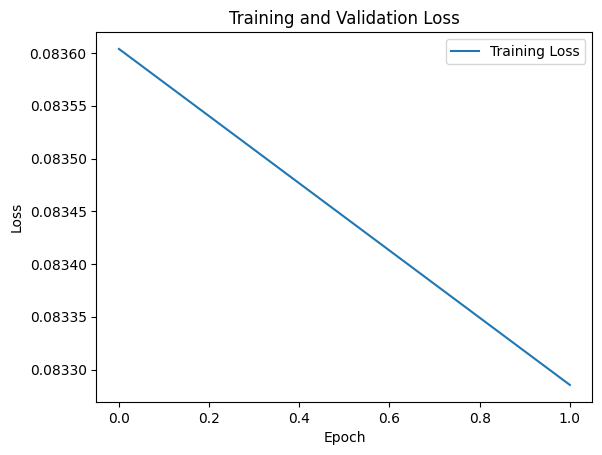

In [4]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


here is the explanation of the above
training Loss Curve:

The line labeled "Training Loss" shows how the model's loss on the training data changes over the epochs.
A steadily decreasing training loss indicates that the model is learning and fitting the training data better over time.
However, if the training loss decreases very quickly and reaches a very low value, it might be a sign of overfitting (if the validation loss doesn't follow the same trend).
Validation Loss Curve (if available):

If you have provided validation data during training, the code plots the "Validation Loss" curve as well.
This curve shows the model's loss on unseen (validation) data.
Ideally, both training and validation loss should decrease over time, which indicates that the model generalizes well.
If the validation loss starts increasing while training loss continues to drop, it suggests that the model might be overfitting the training data.
X-Axis (Epoch):

The x-axis represents the number of epochs (complete passes through the training data).
By looking at how the losses change as the epoch number increases, you can decide if you need more training or if you should stop early.
Y-Axis (Loss):

The y-axis represents the loss value (for example, mean squared error if you're using 'mse' as your loss function).
Lower loss values mean that the model's predictions are closer to the true values.
Overall Analysis:

Steady Decrease: If both curves steadily decrease, it indicates that your model is learning effectively.
Divergence: If the training loss keeps decreasing but the validation loss levels off or increases, it indicates overfitting.
Plateau: If both curves plateau, it might mean that your model has reached its learning capacity or that you need to adjust the learning rate or other hyperparameters.


test data loading

In [37]:
import pandas as pd
!unzip -o "/content/drive/MyDrive/test_data.csv.zip" -d /content/

# Update the path to your test dataset on Drive.
csv_path = "/content/test_data.csv"
test_df = pd.read_csv(csv_path)
print("Original test_df shape:", test_df.shape)

# Define your target column.
target_column = 'contest-precip-14d__precip'

# Drop non-numeric columns such as 'startdate' and 'climateregions__climateregion'
cols_to_drop = ['startdate', 'climateregions__climateregion']
test_df = test_df.drop(cols_to_drop, axis=1, errors='ignore')
print("Columns after dropping unwanted ones:", test_df.columns.tolist())



Archive:  /content/drive/MyDrive/test_data.csv.zip
  inflating: /content/test_data.csv  
Original test_df shape: (31354, 245)
Columns after dropping unwanted ones: ['index', 'lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate

handling missing values in test data

In [38]:
# Separate features and target for test data.
features_test = test_df.drop(target_column, axis=1)
target_test = test_df[target_column]

# Check for missing values.
print("Missing values in test features:\n", features_test.isnull().sum().sort_values(ascending=False).head(10))
print("Missing values in test target:", target_test.isnull().sum())

# Impute missing values in test features with the median.
features_test = features_test.fillna(features_test.median())

# Drop rows where the test target is missing.
mask = target_test.notnull()
features_test = features_test[mask]
target_test = target_test[mask]

# Convert any non-numeric columns to numeric (if any) and fill new NaNs.
features_test = features_test.apply(pd.to_numeric, errors='coerce')
features_test = features_test.fillna(features_test.median())

# Verify that there are no missing values.
assert not features_test.isnull().any().any(), "Missing values remain in test features!"
assert not target_test.isnull().any(), "Missing values remain in test target!"

print("Test data cleaned. Features shape:", features_test.shape)


Missing values in test features:
 index                                 0
lat                                   0
lon                                   0
contest-pevpr-sfc-gauss-14d__pevpr    0
nmme0-tmp2m-34w__cancm30              0
nmme0-tmp2m-34w__cancm40              0
nmme0-tmp2m-34w__ccsm30               0
nmme0-tmp2m-34w__ccsm40               0
nmme0-tmp2m-34w__cfsv20               0
nmme0-tmp2m-34w__gfdlflora0           0
dtype: int64
Missing values in test target: 0
Test data cleaned. Features shape: (31354, 242)


In [43]:
# --- Training Data Preprocessing (ensure this cell is run first) ---
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [48]:
# Load training data (update the path accordingly)
csv_path = "/content/train_data.csv"
import pandas as pd

# Correctly enclosed file path in quotes
train_df = pd.read_csv('/content/train_data.csv')
print("Training data shape:", train_df.shape)



Training data shape: (375734, 246)


In [49]:
# --- Training Data Preprocessing (ensure this cell is run first) ---
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load training data (update the path accordingly)
csv_path = "/content/train_data.csv"
import pandas as pd

# Correctly enclosed file path in quotes
train_df = pd.read_csv('/content/train_data.csv')
print("Training data shape:", train_df.shape)

# Define the target column and drop unwanted columns (like 'startdate' and 'climateregions__climateregion')
target_column = 'contest-precip-14d__precip'
cols_to_drop = ['startdate', 'climateregions__climateregion']
train_df = train_df.drop(cols_to_drop, axis=1, errors='ignore')
print("Columns after dropping unwanted ones:", train_df.columns.tolist())

# Separate features and target
features_df = train_df.drop(target_column, axis=1)
target_series = train_df[target_column]

# Handle missing values in training features (impute using median)
features_df = features_df.fillna(features_df.median())
features_df = features_df.apply(pd.to_numeric, errors='coerce')
features_df = features_df.fillna(features_df.median())

# Optionally, drop rows where the target is missing
mask = target_series.notnull()
features_df = features_df[mask]
target_series = target_series[mask]
print("Processed training features shape:", features_df.shape)

# Fit the scaler on the training features
scaler = StandardScaler()
scaler.fit(features_df)
features_scaled = pd.DataFrame(scaler.transform(features_df), columns=features_df.columns)
print("Training features scaled. Sample data:")
print(features_scaled.head())


Training data shape: (375734, 246)
Columns after dropping unwanted ones: ['index', 'lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmm

test data preprocessing

In [50]:
# --- Test Data Preprocessing ---
# Load test data (update the path accordingly)
csv_path = "/content/test_data.csv"
test_df = pd.read_csv('/content/train_data.csv')
print("Original test data shape:", test_df.shape)

# Drop the same unwanted columns from test data
test_df = test_df.drop(cols_to_drop, axis=1, errors='ignore')

# Separate test features and target
features_test = test_df.drop(target_column, axis=1)
target_test = test_df[target_column]

# Handle missing values in test data similarly
features_test = features_test.fillna(features_test.median())
features_test = features_test.apply(pd.to_numeric, errors='coerce')
features_test = features_test.fillna(features_test.median())
target_test = target_test.fillna(target_test.median())
print("Test features shape after cleaning:", features_test.shape)

# Transform test features using the already-fitted scaler
features_test_scaled = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
print("Test features scaled. Sample data:")
print(features_test_scaled.head())


Original test data shape: (375734, 246)
Test features shape after cleaning: (375734, 243)
Test features scaled. Sample data:
      index       lat       lon  contest-pevpr-sfc-gauss-14d__pevpr  \
0 -1.732046 -2.354642  1.159198                           -0.200642   
1 -1.732037 -2.354642  1.159198                           -0.241533   
2 -1.732028 -2.354642  1.159198                           -0.282980   
3 -1.732019 -2.354642  1.159198                           -0.259808   
4 -1.732009 -2.354642  1.159198                           -0.199430   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                  1.663408                  1.707969   
1                  1.663408                  1.707969   
2                  1.663408                  1.707969   
3                  1.663408                  1.707969   
4                  1.663408                  1.707969   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                 1.92677

EDA

Summary statistics for training features:
              index           lat           lon  \
count  3.757340e+05  3.757340e+05  3.757340e+05   
mean  -5.325279e-17  2.372170e-16  4.865368e-16   
std    1.000001e+00  1.000001e+00  1.000001e+00   
min   -1.732046e+00 -2.354642e+00 -1.903869e+00   
25%   -8.660231e-01 -7.296124e-01 -8.011648e-01   
50%    0.000000e+00 -7.376919e-03  5.649392e-02   
75%    8.660231e-01  8.954175e-01  9.141526e-01   
max    1.732046e+00  1.617653e+00  1.771811e+00   

       contest-pevpr-sfc-gauss-14d__pevpr  nmme0-tmp2m-34w__cancm30  \
count                        3.757340e+05              3.757340e+05   
mean                         1.210291e-17              2.263244e-16   
std                          1.000001e+00              1.000001e+00   
min                         -1.408760e+00             -2.352149e+00   
25%                         -8.717552e-01             -8.447172e-01   
50%                         -1.333977e-01             -7.776212e-02   
7

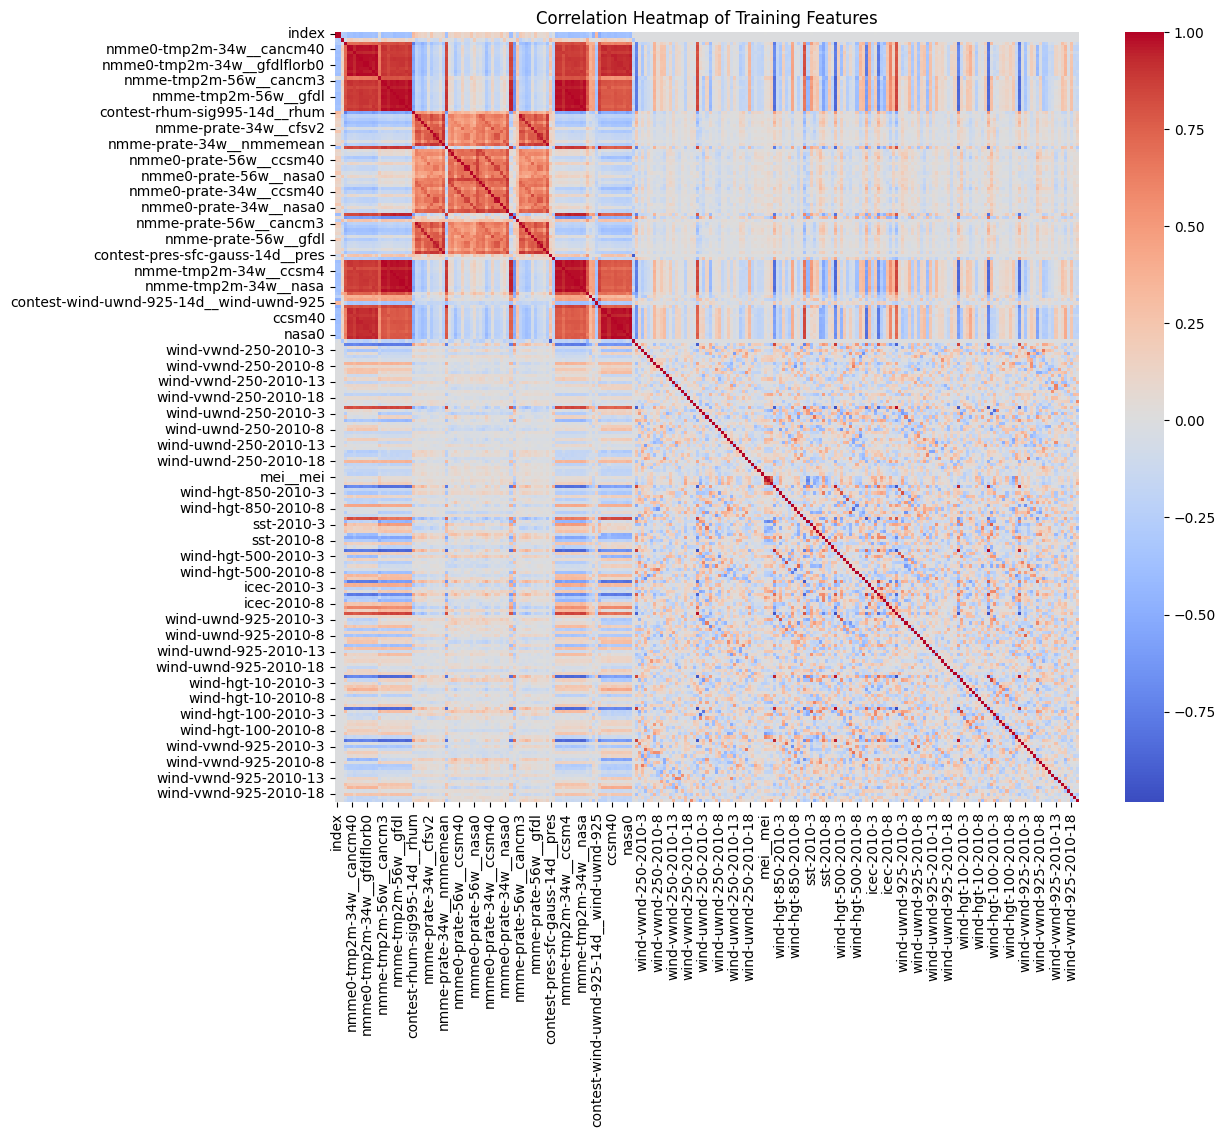

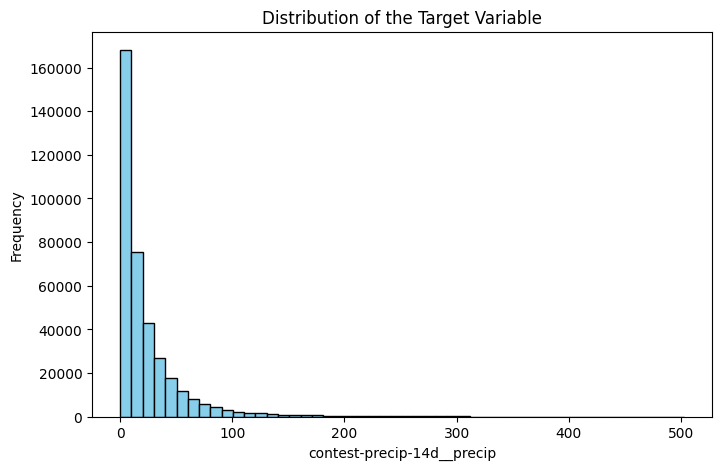

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display summary statistics for the scaled training features.
print("Summary statistics for training features:")
print(features_scaled.describe())

# Plot a correlation heatmap of the training features.
plt.figure(figsize=(12, 10))
sns.heatmap(features_scaled.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Training Features")
plt.show()

# Plot a histogram of the target variable.
plt.figure(figsize=(8, 5))
plt.hist(target_series, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of the Target Variable")
plt.xlabel(target_column)
plt.ylabel("Frequency")
plt.show()


TIME SERIES CROSS VALIDATION

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define a helper function to create sequences.
def create_sequences_cv(X, y, sequence_length):
    """
    Converts DataFrame X and Series y into overlapping sequences for LSTM.
    Returns: numpy arrays (X_seq, y_seq) where each X_seq[i] has shape (sequence_length, n_features)
             and y_seq[i] is the target at time step i+sequence_length.
    """
    X_array = X.values.astype(np.float32)
    y_array = y.values.astype(np.float32)
    X_seq, y_seq = [], []
    for i in range(len(X_array) - sequence_length):
        X_seq.append(X_array[i:i+sequence_length])
        y_seq.append(y_array[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Set cross-validation and sequence parameters
n_splits = 5            # Number of CV splits
sequence_length = 10    # Number of timesteps per sequence
batch_size = 32         # Batch size for training

# Create a TimeSeriesSplit instance.
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare to store validation losses from each fold.
cv_losses = []

fold = 1
for train_index, val_index in tscv.split(features_scaled):
    print(f"\n--- Fold {fold} ---")

    # Split the preprocessed training data into CV folds.
    X_train_fold = features_scaled.iloc[train_index]
    y_train_fold = target_series.iloc[train_index]
    X_val_fold = features_scaled.iloc[val_index]
    y_val_fold = target_series.iloc[val_index]

    # Create overlapping sequences for training and validation
    X_train_seq, y_train_seq = create_sequences_cv(X_train_fold, y_train_fold, sequence_length)
    X_val_seq, y_val_seq = create_sequences_cv(X_val_fold, y_val_fold, sequence_length)

    print(f"Fold {fold} training sequences shape: {X_train_seq.shape}")
    print(f"Fold {fold} validation sequences shape: {X_val_seq.shape}")

    # Build a simple LSTM model for this fold.
    n_features = X_train_seq.shape[2]  # Number of features per time step
    model_cv = Sequential([
        LSTM(50, activation='tanh', input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model_cv.compile(optimizer=optimizer, loss='mse')

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model on this fold
    history_cv = model_cv.fit(
        X_train_seq, y_train_seq,
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate on the validation fold
    val_loss = model_cv.evaluate(X_val_seq, y_val_seq, verbose=0)
    print(f"Fold {fold} validation loss: {val_loss}")
    cv_losses.append(val_loss)
    fold += 1

# Compute and print overall CV error metrics.
print("\nCross-Validation Results:")
print("Validation Losses:", cv_losses)
print("Average CV Loss:", np.mean(cv_losses))



--- Fold 1 ---
Fold 1 training sequences shape: (62614, 10, 243)
Fold 1 validation sequences shape: (62612, 10, 243)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 1812.5901 - val_loss: 860.5972
Epoch 2/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 1368.0826 - val_loss: 738.6958
Epoch 3/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - loss: 1116.0471 - val_loss: 665.7173
Epoch 4/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 967.1464 - val_loss: 595.2549
Epoch 5/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 816.4134 - val_loss: 560.6525
Epoch 6/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 701.0974 - val_loss: 533.5129
Epoch 7/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 610.4003 - val_loss: 499.6338
Epoch 8/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 529.5499 - val_loss: 489.8735
Epoch 9/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 466.7957 - val_loss: 478.1237
Epoch 10/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 429.1439 - val_loss: 451.7991
Epoch 11/20
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step